In [33]:
import numpy as np
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.data.Metrics import relRMSE
from ssapp.Utils import FigureSaver
from torch.utils.data.dataloader import DataLoader
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,Matern
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver('GaussianProcessHyperParameterTuning')

dataset_names = ['ReflectorCutDataset2','CircularHornDataset1','PatchAntennaDataset2','MLADataset1']

dataset_name = dataset_names[0]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
def score(model,x,y):
    pred = model.predict(x)
    return relRMSE(y.reshape(len(y),-1),pred.reshape(len(pred),-1))

for dataset_name in dataset_names:
    train_dataset = load_serialized_dataset(dataset_name+'_Train')
    val_dataset = load_serialized_dataset(dataset_name+'_Val')

    train_dataloader = DataLoader(train_dataset,batch_size=len(train_dataset),shuffle=True,num_workers=4)
    val_dataloader = DataLoader(val_dataset,batch_size=len(val_dataset),shuffle=True,num_workers=4)

    train_params, train_fields = next(iter(train_dataloader))
    val_params, val_fields = next(iter(val_dataloader))

    kernel = ConstantKernel(10, constant_value_bounds="fixed") * RBF(length_scale=0.335,length_scale_bounds='fixed')
    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel=kernel))])



    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))
    print(f'Train Loss: {dataset_name} ,{score(std_gp,train_params,train_fields):.3e}')
    print(f'Val Loss: {dataset_name} ,{score(std_gp,val_params,val_fields):.3e}')


Train Loss: ReflectorCutDataset2 ,4.170e-11
Val Loss: ReflectorCutDataset2 ,1.499e+00
Train Loss: CircularHornDataset1 ,5.369e-04
Val Loss: CircularHornDataset1 ,1.404e-03
Train Loss: PatchAntennaDataset2 ,3.164e-11
Val Loss: PatchAntennaDataset2 ,5.288e-03
Train Loss: MLADataset1 ,9.985e-12
Val Loss: MLADataset1 ,1.477e+02


In [13]:
train_dataset = load_serialized_dataset(dataset_names[3]+'_Train')
val_dataset = load_serialized_dataset(dataset_names[3]+'_Val')

train_dataloader = DataLoader(train_dataset,batch_size=len(train_dataset),shuffle=True,num_workers=4)
val_dataloader = DataLoader(val_dataset,batch_size=len(val_dataset),shuffle=True,num_workers=4)

train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))




Train Loss: MLADataset1 0.44081235683403575
Val Loss: MLADataset1 0.4663896138960028


length_scale: 1.0
Train Loss: MLADataset1 6.602828439243955e-11
Val Loss: MLADataset1 0.5865293140037178
length_scale: 2.114742526881128
Train Loss: MLADataset1 3.500209673790466e-09
Val Loss: MLADataset1 0.20488844567393433
length_scale: 4.47213595499958
Train Loss: MLADataset1 1.315410508109682e-05
Val Loss: MLADataset1 0.1844155736533347
length_scale: 9.457416090031758
Train Loss: MLADataset1 0.019112764230072972
Val Loss: MLADataset1 0.15558006461982635
length_scale: 20.0
Train Loss: MLADataset1 0.1381289306008729
Val Loss: MLADataset1 0.21333487808336102


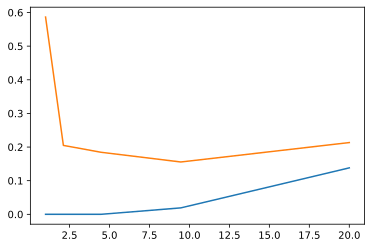

In [17]:
length_scale_list = np.logspace(0,1,5,base=20)

length_scale_train_loss = np.array([])
length_scale_val_loss = np.array([])

for length_scale in length_scale_list:
    kernel = ConstantKernel(1, constant_value_bounds="fixed") * RBF(length_scale=length_scale,length_scale_bounds='fixed')
    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel=kernel))])
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    length_scale_train_loss = np.append(length_scale_train_loss,score(std_gp,train_params,train_fields))
    length_scale_val_loss = np.append(length_scale_val_loss,score(std_gp,val_params,val_fields))

    print('length_scale:',length_scale)
    print('Train Loss:',dataset_name,length_scale_train_loss[-1])
    print('Val Loss:',dataset_name,length_scale_val_loss[-1])

plt.figure()
plt.plot(length_scale_list,length_scale_train_loss)
plt.plot(length_scale_list,length_scale_val_loss)


In [37]:
kernel = ConstantKernel(20, constant_value_bounds="fixed") * RBF(length_scale=10,length_scale_bounds='fixed')
std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel=kernel))])
std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

pred = std_gp.predict(val_params).reshape(-1,361,3,4)



In [ ]:
score(std_gp,val_params,val_fields)

Val Loss: 1.458894e-01


Text(0.5, 1.0, 'Cross-Polar')

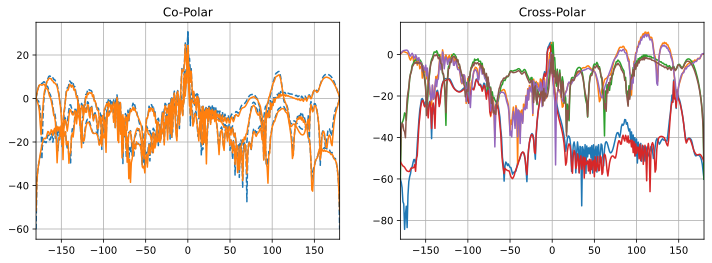

<Figure size 432x288 with 0 Axes>

In [66]:
mag_co = lambda a,idx: 20*np.log10(np.sqrt(a[idx,:,:,0]**2+a[idx,:,:,1]**2))
mag_cross = lambda a,idx: 20*np.log10(np.sqrt(a[idx,:,:,2]**2+a[idx,:,:,3]**2))

print(f'Val Loss: {relRMSE(val_fields.reshape(len(val_fields),-1),pred.reshape(len(pred),-1)):3e}')

theta = np.linspace(-180,180,361)

IDX = 200
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
axs[0].plot(theta,mag_co(pred,IDX),color='C0',linestyle = '--',label='Predicted')
axs[0].plot(theta,mag_co(val_fields,IDX),color='C1',linestyle = '-',label='Truth')
axs[0].grid()
axs[0].set_xlim(-180,180)
axs[0].set_title('Co-Polar')
plt.figure()
axs[1].plot(theta,mag_cross(pred,IDX))
axs[1].plot(theta,mag_cross(val_fields,IDX))
axs[1].grid()
axs[1].set_xlim(-180,180)
axs[1].set_title('Cross-Polar')